In [207]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [208]:
import os
path='/content/drive/MyDrive/Untitled folder (1)/gpcs301'
os.chdir(path)
print(os.listdir(path))

['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']


In [209]:
import jax as jnp
from jax import grad, jit, vmap
from jax import random
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import pandas as pd
import unittest
import scipy 
from scipy.stats import norm

%matplotlib inline



In [210]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [211]:
train['SalePrice'].describe()

count     1,460.00
mean    180,921.20
std      79,442.50
min      34,900.00
25%     129,975.00
50%     163,000.00
75%     214,000.00
max     755,000.00
Name: SalePrice, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


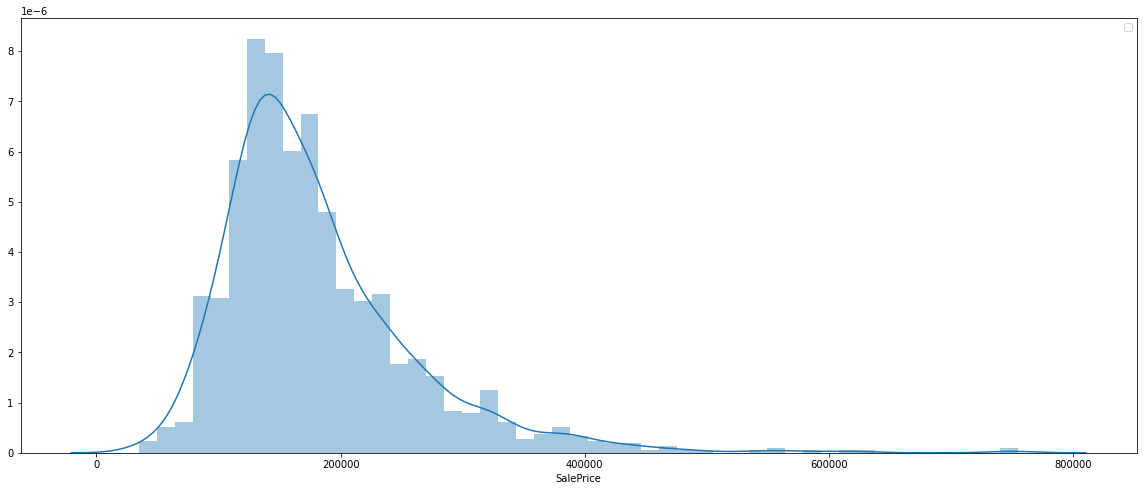

In [212]:
plt.figure(figsize=(20,8))
sns.distplot(train['SalePrice'],fit_kws={'color':'red','label':'norm'})
plt.ylabel('')
plt.legend()
plt.show()

In [213]:
# Let's select the columns of the train set with numerical data
df_train_num = train.select_dtypes(exclude=["object"])
df_train_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.00,8450,7,5,2003,2003,196.00,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.00,9600,6,8,1976,1976,0.00,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.00,11250,7,5,2001,2002,162.00,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.00,9550,7,5,1915,1970,0.00,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.00,14260,8,5,2000,2000,350.00,655,...,192,84,0,0,0,0,0,12,2008,250000


In [214]:
pd.options.display.float_format = "{:,.2f}".format

corr_matrix = df_train_num.corr()

corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0

In [215]:
df_num_corr = df_train_num.corr()["SalePrice"][:-1]
high_features_list = df_num_corr[abs(
    df_num_corr) >= 0.5].sort_values(ascending=False)
print(
    f"{len(high_features_list)} strongly correlated values with SalePrice:\n{high_features_list}\n")


10 strongly correlated values with SalePrice:
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
Name: SalePrice, dtype: float64



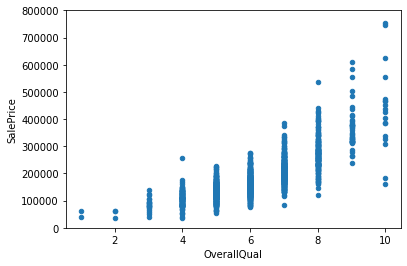

In [216]:
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

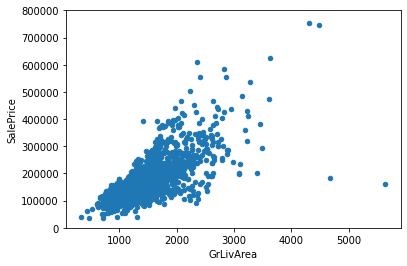

In [217]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

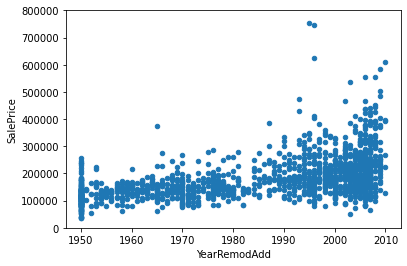

In [218]:
var = 'YearRemodAdd'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [219]:
low_features_list = df_num_corr[(abs(df_num_corr) < 0.5) & (
    abs(df_num_corr) >= 0.3)].sort_values(ascending=False)
print(
    f"{len(low_features_list)} slightly correlated values with SalePrice:\n{low_features_list}")

8 slightly correlated values with SalePrice:
GarageYrBlt   0.49
MasVnrArea    0.48
Fireplaces    0.47
BsmtFinSF1    0.39
LotFrontage   0.35
WoodDeckSF    0.32
2ndFlrSF      0.32
OpenPorchSF   0.32
Name: SalePrice, dtype: float64


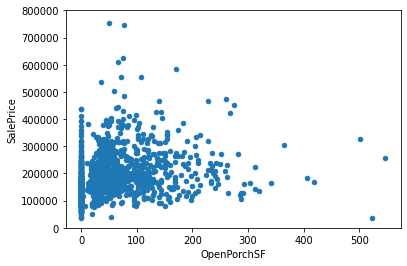

In [220]:
var = 'OpenPorchSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

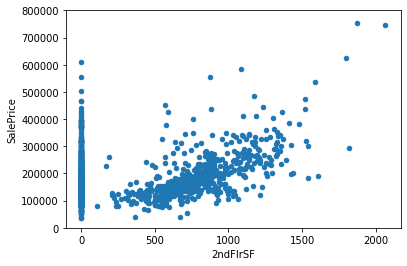

In [221]:
var = '2ndFlrSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [222]:
X = train.drop('SalePrice', axis=1)
y =train.SalePrice
X.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [223]:
features_with_na=train.isnull().sum().sort_values(ascending=False)
percentage=(train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([features_with_na, percentage], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)



,Total,Percent
PoolQC,1453,1.00
MiscFeature,1406,0.96
Alley,1369,0.94
Fence,1179,0.81
FireplaceQu,690,0.47
LotFrontage,259,0.18
GarageYrBlt,81,0.06
GarageCond,81,0.06
GarageType,81,0.06
GarageFinish,81,0.06


In [224]:
train_id = train['Id']
test_id = test['Id']

# drop them from dataset beacuse we don't need them in the model
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
# concatente train and test data do do our preprocessing in both of them
ntrain = train.shape[0]
ntest = test.shape[0]

y_train= train['SalePrice']
train.drop(['SalePrice'], axis=1, inplace=True)
all_data = pd.concat((train, test), ignore_index=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [225]:

#drop columns that have a lot of null values and will not affect our model
all_data.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'], axis=1, inplace=True)

all_data.shape

(2919, 74)